In [1]:
%load_ext autoreload
%autoreload 2

import os
import glob
from operator import attrgetter
from collections import defaultdict

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from infomap import Infomap

from analysis import *
from hypergraph.network import Tree, Network

In [2]:
networks = sorted(Tree.from_files(glob.glob("output/*tree")), key=attrgetter("codelength"), reverse=True)

ground_truth = next((network for network in networks if "multilayer_self_links" in network.filename))

ground_truth.match_ids(networks)

def write_networks(networks, outdir):
    for i, network in enumerate(networks):
        basename = os.path.splitext(os.path.basename(network.filename))[0]
        filename = os.path.join(outdir, f"{i}_{basename}.tree")
        with open(filename, "w") as fp:
            network.write(fp)


write_networks(networks, "output/matched_ids")

summarize(networks)

,network,num states,num links,levels,top modules,codelength,mean assignments,mean eff. assignments
0,bipartite,16,33,2,2,2.96770,1.0,1.000000
1,unipartite (directed),11,31,2,3,2.90090,1.0,1.000000
2,bipartite (non-bt),27,53,2,3,2.90090,1.0,1.000000
3,multilayer,17,69,2,3,2.88697,1.1,1.088988
4,multilayer (self links),17,99,2,3,2.52146,1.0,1.000000
5,unipartite (directed self links),11,41,2,3,2.52146,1.0,1.000000
6,multilayer (similarity),17,69,2,4,2.47323,1.3,1.288988
7,multilayer (similarity self links),17,99,2,4,2.46591,1.3,1.288988


In [3]:
from os import path, remove
from operator import attrgetter

d = defaultdict(list)

#ref_partition = Tree.from_file("ref_directed.ftree")
#ref_partition_self_links = Tree.from_file("ref_directed_self_links.ftree")

two_level_ref_partition = Tree.from_file("output/unipartite_directed.ftree")
two_level_ref_partition_self_links = Tree.from_file("output/unipartite_directed_self_links.ftree")

for network in sorted(glob.glob("output/multilayer*_states.net"), key=len):
    d["filename"].append(" ".join(os.path.basename(network).split("_")[:-1]))

    self_links =  "self_links" in network
    include_self_links = "-k" if self_links else ""

    #ref = ref_partition_self_links if self_links else ref_partition
    
    #cluster_data_tree = ref.cluster_data(Network.from_file(network))
   
    #temp_filename = path.basename(network) + ".tree"
    
    #with open(temp_filename, "w") as temp_fp:
    #    for node in cluster_data_tree.nodes:
    #        node.write(temp_fp)

    #im = Infomap(f"-0 --silent --cluster-data {temp_filename} --directed {include_self_links}")
    #im.read_file(network)
    #im.run()
    
    #os.remove(temp_filename)
    
    #l1, t1, c1 = im.max_depth, im.num_top_modules, im.codelength

    two_level_ref = two_level_ref_partition_self_links if self_links else two_level_ref_partition
    
    basename = os.path.splitext(os.path.basename(network))[0]
    
    im = Infomap(f"-0 --silent --directed --no-infomap {include_self_links}")
    im.read_file(network)
    im.initial_partition = two_level_ref.initial_partition(Network.from_file(network))
    im.run()
    im.write_tree(basename + "-no-infomap.tree", states=True)
    
    l2, t2, c2 = im.max_depth, im.num_top_modules, im.codelength

    im = Infomap(f"--silent -N20 -2 --directed {include_self_links}")
    im.read_file(network)
    im.run()
    im.write_tree(basename + "-optimized.tree", states=True)
    
    l3, t3, c3 = im.max_depth, im.num_top_modules, im.codelength

    #d["levels (multilevel)"].append(l1)
    d["levels (no-infomap)"].append(l2)
    d["levels (optimized)"].append(l3)

    #d["modules (multilevel)"].append(t1)
    d["modules (no-infomap)"].append(t2)
    d["modules (optimized)"].append(t3)

    #d["L (multilevel)"].append(c1)
    d["L (no-infomap)"].append(c2)
    d["L (2-level optimized)"].append(c3)
    

for tree in glob.glob("*.tree"):
    os.remove(tree)

pd.DataFrame(data=d)

,filename,levels (no-infomap),levels (optimized),modules (no-infomap),modules (optimized),L (no-infomap),L (2-level optimized)
0,multilayer,2,2,3,3,2.885342,2.869811
1,multilayer self links,2,2,3,3,2.515142,2.515142
2,multilayer similarity,2,2,3,4,2.870959,2.460022
3,multilayer similarity self links,2,2,3,4,2.503713,2.440438


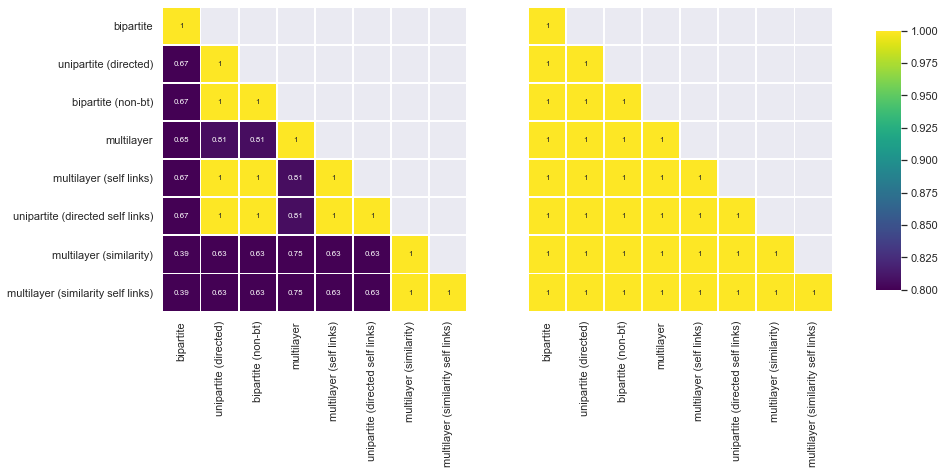

In [4]:
f, ax = plt.subplots(1, 2, figsize=(12,6))
cbar_ax = f.add_axes([0.95, 0.2, 0.03, 0.6])

ami_score = ami(networks)
jaccard_score = weighted_jaccard_dist(networks)

plot_heatmap(ami_score, ax=ax[0], cbar=False, yticklabels=ami_score.columns);
plot_heatmap(jaccard_score, ax=ax[1], cbar_ax=cbar_ax, yticklabels=False);